In [1]:
# let's see how good we can get something if we just use a simple cnn on the raw moonboard data
import os
import pickle
import numpy as np
import tensorflow as tf
import math 


from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
print(cwd)
parent_wd = cwd.replace('/model', '')
raw_data_path = os.path.join(parent_wd, 'raw_data/moonGen_scrape_2016')

/Users/markliu/moonboard


In [3]:
raw_data_path

'/Users/markliu/moonboard/raw_data/moonGen_scrape_2016'

In [4]:
with open(raw_data_path, 'rb') as f:
    raw_data = pickle.load(f)

In [6]:
print(list(raw_data.items())[3][1])

{'problem_name': 'GULAG', 'info': ['micklevin', '1 climber has repeated this problem', '7A', 'Feet follow hands', ''], 'url': 'https://moonboard.com/Problems/View/367885/gulag', 'num_empty': 1, 'num_stars': 2, 'moves': [{'Id': 2119166, 'Description': 'A5', 'IsStart': True, 'IsEnd': False}, {'Id': 2119167, 'Description': 'B8', 'IsStart': False, 'IsEnd': False}, {'Id': 2119168, 'Description': 'D12', 'IsStart': False, 'IsEnd': False}, {'Id': 2119169, 'Description': 'F14', 'IsStart': False, 'IsEnd': False}, {'Id': 2119170, 'Description': 'I18', 'IsStart': False, 'IsEnd': True}], 'grade': '7A', 'UserGrade': None, 'isBenchmark': False, 'repeats': 1, 'ProblemType': None, 'IsMaster': False, 'setter': {'Id': '05f91964-f58c-4a49-af50-abec02f71300', 'Nickname': 'micklevin', 'Firstname': 'Mick', 'Lastname': 'Levin', 'City': 'Halifax', 'Country': 'Canada', 'ProfileImageUrl': '/Content/Account/Users/Profile/05f91964-f58c-4a49-af50-abec02f71300.jpg?637231996827206508', 'CanShareData': True}}


In [7]:
all_grades = set()

for problem in list(raw_data.items()):
    try:
        all_grades.add(problem[1]['grade'])
    except:
        print("failed to add grade for problem ", problem[0])
        
print(all_grades)

failed to add grade for problem  356367
failed to add grade for problem  353028
failed to add grade for problem  348825
failed to add grade for problem  333117
failed to add grade for problem  332272
failed to add grade for problem  314544
failed to add grade for problem  314454
failed to add grade for problem  312470
failed to add grade for problem  311460
failed to add grade for problem  310781
failed to add grade for problem  309769
failed to add grade for problem  309545
failed to add grade for problem  309079
failed to add grade for problem  287806
failed to add grade for problem  287597
failed to add grade for problem  280514
failed to add grade for problem  280420
failed to add grade for problem  264916
failed to add grade for problem  263758
failed to add grade for problem  256115
failed to add grade for problem  242702
failed to add grade for problem  233728
failed to add grade for problem  222189
failed to add grade for problem  207982
failed to add grade for problem  206103


In [8]:
def get_grade_map():
    """
    Defines a mapping of Fontainebleau grades to integer values
    """
    grade_map = {
        '6B': 0,  # V4
        '6B+': 1, # V4
        '6C': 2,  # V5
        '6C+': 3, # V5
        '7A': 4,  # V6
        '7A+': 5, # V7
        '7B': 6,  # V8
        '7B+': 7, # V8
        '7C': 8,  # V9
        '7C+': 9, # V10
        '8A': 10,  # V11
        '8A+': 11, # V12
        '8B': 12,  # V13
        '8B+': 13, # V14
    }
    return grade_map

def get_reverse_grade_map():
    """
    Map scores back to font grades - just use array
    """
    return ['6B', '6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+', '8A', '8A+', '8B', '8B+']



def get_v_grade_map():
    """
    Defines a mapping of v grades to integer values
    """
    grade_map = {
        '6B': 0,  # V4
        '6B+': 0, # V4
        '6C': 1,  # V5
        '6C+': 1, # V5
        '7A': 2,  # V6
        '7A+': 3, # V7
        '7B': 4,  # V8
        '7B+': 4, # V8
        '7C': 5,  # V9
        '7C+': 6, # V10
        '8A': 7,  # V11
        '8A+': 8, # V12
        '8B': 9,  # V13
        '8B+': 10, # V14
    }
    return grade_map

def coordinateToString(coordinate):
    """ convert (9.0 ,4.0) to "J5" """
    alphabetList = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"]
    return str(alphabetList[int(coordinate[0])]) + str(int(coordinate[1]) + 1)

def stringToCoordinate(coordinate_string):
    """ convert "J5" to (9.0,4.0) """
    x = ord(coordinate_string[0])-ord('A')
    y = int(coordinate_string[1:])-1
    return (x,y)

In [9]:
print(stringToCoordinate("J5"))
print(coordinateToString((9,4)))

(9, 4)
J5


In [ ]:
print(list(raw_data.items())[2][1])

In [10]:
def convert_problem_to_input(holds):
    # each problem is on 11x18 board, encode as (x,y) coordinates, zero-indexed, starting from bottom left corner
    inp = np.zeros((11,18))
    for hold in holds:
        hold_string = hold['Description']
        inp[stringToCoordinate(hold_string)] = 1
    return inp

# debugging - back to sequence of moves
def convert_input_to_problem(inp):
    # each problem is on 11x18 board
    holds = []
    nonzero_idxs = np.argwhere(inp!= 0)
    for idx in nonzero_idxs:
        holds.append(coordinateToString(idx))
    return holds

def convert_problem_to_debug(inp):
    # we want to encode the problem in a matrix where if you print it, it actually looks like the moonboard
    # this looks something like:
    # debug[17-y]
    debug = np.zeros((18,11))
    for hold in holds:
        hold_string = hold['Description']
        x,y = stringToCoordinate(hold_string)
        debug[17-y][x] = 1
    return debug

In [11]:
holds = list(raw_data.items())[2][1]['moves']
sample_input = convert_problem_to_input(holds)
sample_holds = convert_input_to_problem(sample_input)
print(convert_problem_to_debug(holds))
print(sample_holds)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['G4', 'G10', 'G15', 'H8', 'K12', 'K18']


In [12]:
def build_inputs_and_outputs(raw_data, limit=None, print_progress=False):
    count = 0
    grade_map = get_grade_map()
    xs = []
    ys = []
    ids = []
    for problem_desc in raw_data.items():
        if limit != None and count >= limit:
            break
        if print_progress:
            if count % 100 == 0:
                print("working on item ", count, " out of ", len(raw_data.items()))
        problem = problem_desc[1]
        try:
            x = convert_problem_to_input(problem['moves'])
            y = grade_map[problem['grade']]
            xs.append(x)
            ys.append(y)
            ids.append(problem['problem_name'])
        except Exception as e:
            print("failed to convert problem ", problem_desc[0])
            print(e)
        count += 1
    return xs,ys,ids

In [13]:
xs,ys,ids = build_inputs_and_outputs(raw_data, print_progress=True)

working on item  0  out of  30673
working on item  100  out of  30673
working on item  200  out of  30673
working on item  300  out of  30673
working on item  400  out of  30673
working on item  500  out of  30673
working on item  600  out of  30673
working on item  700  out of  30673
working on item  800  out of  30673
working on item  900  out of  30673
working on item  1000  out of  30673
working on item  1100  out of  30673
working on item  1200  out of  30673
working on item  1300  out of  30673
working on item  1400  out of  30673
working on item  1500  out of  30673
working on item  1600  out of  30673
working on item  1700  out of  30673
working on item  1800  out of  30673
working on item  1900  out of  30673
working on item  2000  out of  30673
working on item  2100  out of  30673
working on item  2200  out of  30673
working on item  2300  out of  30673
working on item  2400  out of  30673
working on item  2500  out of  30673
working on item  2600  out of  30673
working on it

In [ ]:
print(len(xs))

In [14]:
# stack them so they are single numpy arrays
xs = np.stack(xs, axis=0)
ys = np.stack(ys, axis=0)


In [15]:
# split into training/test/validation sets
indices = np.random.permutation(xs.shape[0])
# print(indices)

n_val = 3000
n_test = 3000

val_idxs = indices[0:n_val]
test_idxs = indices[n_val:n_val+n_test]
train_idxs = indices[n_val+n_test:]

x_train, x_test, x_val = xs[train_idxs,:], xs[test_idxs,:], xs[val_idxs,:]
y_train, y_test, y_val = ys[train_idxs], ys[test_idxs], ys[val_idxs]



In [16]:
ids = np.array(ids)
id_train, id_test, id_val = ids[train_idxs], ids[test_idxs], ids[val_idxs]
#ds[train_idxs]

# Model definition

In [17]:


# use a pretty basic one from https://www.tensorflow.org/tutorials/images/cnn
# except swap out the last layer for a single output since we are doing regression
# and change the loss function from a categorical one
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(11, 18, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])

# save initial weights so we can reload from here each time
Wsave = model.get_weights()


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 16, 32)         320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 6, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [19]:
if Wsave:
    model.set_weights(Wsave)

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_val, y_val))

Epoch 1/10
771/771 [==============================] - 3s 3ms/step - loss: 3.1172 - mean_squared_error: 3.1172 - val_loss: 2.7571 - val_mean_squared_error: 2.7571
Epoch 2/10
771/771 [==============================] - 2s 3ms/step - loss: 2.2320 - mean_squared_error: 2.2320 - val_loss: 2.1396 - val_mean_squared_error: 2.1396
Epoch 3/10
771/771 [==============================] - 2s 3ms/step - loss: 2.1079 - mean_squared_error: 2.1079 - val_loss: 2.0807 - val_mean_squared_error: 2.0807
Epoch 4/10
771/771 [==============================] - 2s 3ms/step - loss: 2.0243 - mean_squared_error: 2.0243 - val_loss: 2.0829 - val_mean_squared_error: 2.0829
Epoch 5/10
771/771 [==============================] - 2s 3ms/step - loss: 1.9701 - mean_squared_error: 1.9701 - val_loss: 2.1836 - val_mean_squared_error: 2.1836
Epoch 6/10
771/771 [==============================] - 2s 3ms/step - loss: 1.9154 - mean_squared_error: 1.9154 - val_loss: 2.3905 - val_mean_squared_error: 2.3905
Epoch 7/10
771/771 [========

94/94 [==============================] - 0s 1ms/step


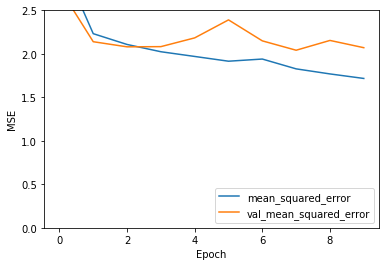

In [20]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0.0, 2.5])
plt.legend(loc='lower right')

#test_loss = model.evaluate(x_test,  y_test, verbose=2)
y_predict = model.predict(x_test)

In [21]:
# let's pick a random one and check
idx = 125
print(convert_problem_to_debug(convert_input_to_problem(x_test[idx])))
print(y_test[idx])
print(y_predict[idx])
print(id_test[idx])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
3
[1.7167133]
TALL POPPY


In [22]:

def predict_single_problem_grade(model, problem):
    return model.predict(problem).item()

def predicted_grade_string(model, problem):
    pred_grade_float = predict_single_problem_grade(model, problem)
    upper_bd = math.ceil(pred_grade_float)
    lower_bd = math.floor(pred_grade_float)
    reverse_grade_map = get_reverse_grade_map()
    return reverse_grade_map[lower_bd]+"-"+reverse_grade_map[upper_bd]

# eval with grade classification
def compute_accuracy(y_true, y_predict):
    """
    Compute the accuracy of the model
    - complete_accurate: the model output match the expected output exactly
    - roughly_accurate: the model output is only different from the expected output by less than or equal to 1 grade.
    """
    complete_accurate = np.sum(y_true == y_predict)/len(y_true)
    roughly_accurate = np.sum(np.abs(y_true - y_predict) <= 1)/len(y_true)
    return (complete_accurate, roughly_accurate)

In [50]:
y_int_predict = [int(y) for y in y_predict]
y_int_predict
compute_accuracy(y_test, y_int_predict)

(0.3546666666666667, 0.7236666666666667)

In [26]:
idx = 125
print(predicted_grade_string(model, np.expand_dims(x_train[idx],0)))
print("actual grade:", get_reverse_grade_map()[y_train[idx]])

1/1 [==============================] - 0s 19ms/step
7B-7B+
actual grade: 7B


In [27]:
model.predict(np.expand_dims(x_train[125],axis=0))


1/1 [==============================] - 0s 16ms/step


array([[6.2430053]], dtype=float32)

In [30]:
model.save("website/moonboard_model.h5")